In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import readdy

In [2]:
readdy.__version__

'v2.0.3-27'

__Prepare the system__

In [3]:
system = readdy.ReactionDiffusionSystem(
    box_size=(4, 4, 4), periodic_boundary_conditions=[True, True, True], unit_system=None)
system.add_species("A", 1.0)
system.add_species("B", 1.0)
system.potentials.add_harmonic_repulsion("A", "B", 1., 1.)

__Prepare the simulation__

In [4]:
simulation = system.simulation(kernel="SingleCPU")

simulation.output_file = "out_rdf.h5"
simulation.observe.rdf(1000, np.linspace(0., 2., 10), ["A"], ["B"], 1. / system.box_volume)
simulation.add_particle("A", [0., 0., 0.])
simulation.add_particle("B", [0., 0., 1.])

__Run the simulation__

In [5]:
if os.path.exists(simulation.output_file):
    os.remove(simulation.output_file)

simulation.progress_output_stride = 1000
simulation.run(n_steps=100000000, timestep=1e-4, show_summary=False)

100%|██████████| 100000/100000 [02:16<00:00, 734.66it/s]


In [6]:
traj = readdy.Trajectory(simulation.output_file)
rdf_times, bin_centers, rdf_values = traj.read_observable_rdf()

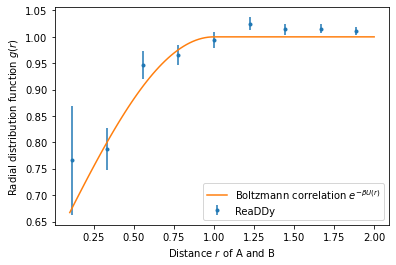

In [7]:
def average_across_first_axis(values):
    n_values = len(values)
    mean = np.sum(values, axis=0) / n_values  # shape = n_bins
    difference = values - mean  # broadcasting starts with last axis
    std_dev = np.sqrt(np.sum(difference * difference, axis=0) / n_values)
    std_err = np.sqrt(np.sum(difference * difference, axis=0) / n_values ** 2)
    return mean, std_dev, std_err

def plot_boltzmann(force_const, interaction_radius):
    def potential(r, force_const, interaction_radius):
        if r < interaction_radius:
            return 0.5 * force_const * np.power(r - interaction_radius, 2.)
        else:
            return 0.

    boltz = lambda r: np.exp(-1. * potential(r, force_const, interaction_radius))
    r_range = np.linspace(0.1, 2., 100)
    b_range = np.fromiter(map(boltz, r_range), dtype=float)
    plt.plot(r_range, b_range, label=r"Boltzmann correlation $e^{-\beta U(r)}$")

mean, std_dev, std_err = average_across_first_axis(rdf_values)
plt.errorbar(bin_centers, mean, yerr=std_err, fmt=".", label="ReaDDy")
plot_boltzmann(1., 1.)
plt.legend()
plt.xlabel(r"Distance $r$ of A and B")
plt.ylabel(r"Radial distribution function $g(r)$")
plt.show()